In [1]:
import torch
import os
import numpy as np

In [ ]:
outputs_path = "/mnt/scratch/kf237/experiments/textCNN_first_tries/outputs_trained_subclasses.pt"
print(os.path.exists(outputs_path))
trained_on = "subclasses"

In [ ]:
outputs_path = "/mnt/scratch/kf237/experiments/textCNN_first_tries/outputs_trained_superclasses.pt"
print(os.path.exists(outputs_path))
trained_on = "superclasses"

True


In [10]:
### CNN

outputs = torch.load(outputs_path)


In [47]:
selected_conv = "convs.2"

##### trained_on_subclasses

In [ ]:
print(type(outputs))

print(outputs.keys())

last_epoch = list(outputs.keys())[-1]

print(last_epoch)

epoch_outputs = outputs[last_epoch]



print(type(epoch_outputs))
print(epoch_outputs.keys())

train_outputs = epoch_outputs["train"]
print(type(train_outputs))
print(train_outputs.keys())
subclasses = train_outputs["labels"]

train_activations = train_outputs["activations"]

print(train_activations.keys())




selected_activations = train_activations[selected_conv]

print(selected_activations.shape)

##### trained_on_superclasses

In [48]:
# print(type(outputs))

# print(outputs.keys())

# last_epoch = list(outputs.keys())[-1]

# print(last_epoch)

# epoch_outputs = outputs[last_epoch]

epoch_outputs = outputs

print(type(epoch_outputs))
print(epoch_outputs.keys())

train_outputs = epoch_outputs["train"]
print(type(train_outputs))
print(train_outputs.keys())

superclasses = train_outputs["superclasses"]
subclasses = train_outputs["subclasses"]

train_activations = train_outputs["activations"]

print(train_activations.keys())




selected_activations = train_activations[selected_conv]

print(selected_activations.shape)

lllabels = train_outputs["labels"]
if trained_on == "superclasses":
    assert torch.equal(superclasses, lllabels), "superclass and labels must be the same!!!"
elif trained_on == "subclasses":
    assert torch.equal(subclasses, lllabels), "subclass and labels must be the same!!!"
else:
    raise ValueError("trained_on must be either superclasses or subclasses")

<class 'dict'>
dict_keys(['train', 'val'])
<class 'dict'>
dict_keys(['loss', 'accuracy', 'activations', 'labels', 'subclasses', 'superclasses'])
dict_keys(['convs.0', 'convs.1', 'convs.2'])
torch.Size([42000, 25000])


In [40]:
print(np.unique(np.array(superclasses)))
aaaaa = selected_activations.max(dim=-1).values

print(aaaaa.shape)

print(selected_activations.shape)

[0 1 2 3 4]
torch.Size([42000])
torch.Size([42000, 25400])


## Plot class counts

In [26]:
import numpy as np


unique_subclass, counts_subclass = np.unique(subclasses.numpy(), return_counts=True)

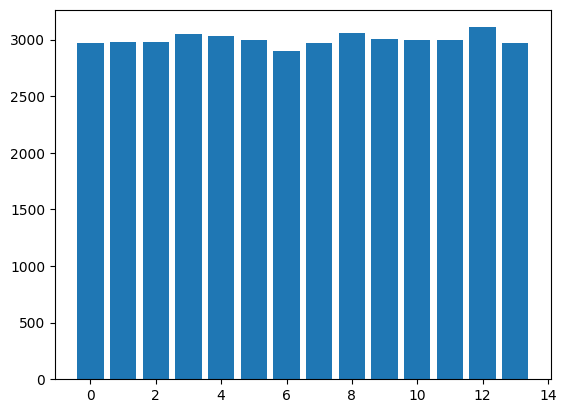

In [27]:
import matplotlib.pyplot as plt



## bar plot

plt.bar(unique_subclass, counts_subclass)
plt.show()

## Train an UMAP reducer

In [49]:
seed = 42

In [50]:
import umap

reducer = umap.UMAP(random_state=seed)

embedding = reducer.fit_transform(selected_activations)


In [51]:

print(embedding.shape)


print(subclasses.shape)

(42000, 2)
torch.Size([42000])


## Plotting the latent space

In [52]:
# Class names
subclass_names = [
    'company', 'educational institution', 'artist', 'athlete', 
    'office holder', 'mean of transportation', 'building', 
    'natural place', 'village', 'animal', 'plant', 
    'album', 'film', 'writtenWork'
]




superclass_names = ["other", "person", "place", "organism", "artwork"]


### The entire latentspace

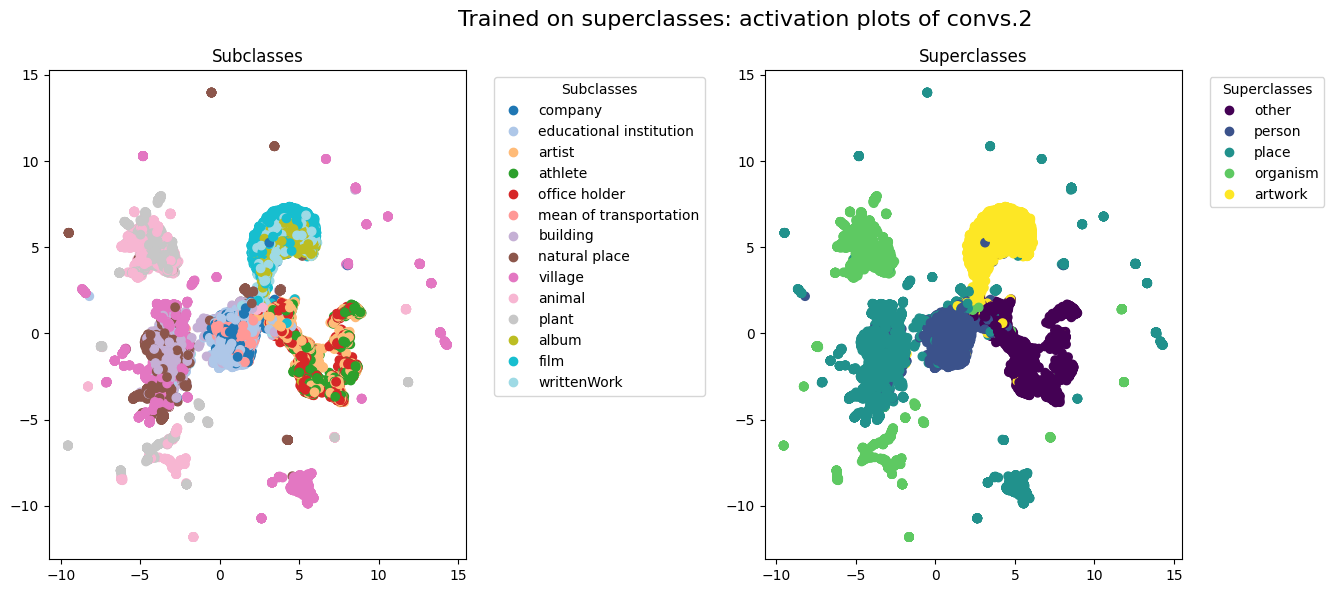

In [53]:
import matplotlib.pyplot as plt
import numpy as np



# Set up the figure and subplots
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))  # Adjust width and height as desired

# Set the overall title for the figure
fig.suptitle(f"Trained on {trained_on}: activation plots of {selected_conv}", fontsize=16)

# First subplot
scatter1 = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=subclasses, cmap="tab20")
legend_elements1, _ = scatter1.legend_elements()
axes[0].legend(legend_elements1, subclass_names, title="Subclasses", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_title("Subclasses")

# Second subplot (same data)
scatter2 = axes[1].scatter(embedding[:, 0], embedding[:, 1], c=superclasses, cmap="viridis")
legend_elements2, _ = scatter2.legend_elements()
axes[1].legend(legend_elements2, superclass_names, title="Superclasses", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_title("Superclasses")

# Adjust layout to make room for legends and title
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust rect to fit legends and title

# Display plot
plt.show()


### only one specific subclass...

In [27]:
#### filter the activations by class


filtered_superclass = 0



## first  construc the binary mask

superclasses_np = np.array(superclasses)

mask = superclasses_np == filtered_superclass

filtered_activations = selected_activations.numpy()[mask]

filtered_subclass_lables = subclasses.numpy()[mask]


unique_labels = np.unique(filtered_subclass_lables)

print(unique_labels)

filtered_subclass_names = [ name for i, name in enumerate(subclass_names) if i in unique_labels]

print(filtered_subclass_names)






[2 3 4]
['artist', 'athlete', 'office holder']


In [ ]:

reducer = umap.UMAP(random_state=seed)
filted_embedding = reducer.fit_transform(filtered_activations)

In [ ]:
import matplotlib.pyplot as plt



# Set the figure size to make the plot wider
plt.figure(figsize=(10, 6))  # Adjust width (12) and height (6) as desired


# Create scatter plot
scatter = plt.scatter(filted_embedding[:, 0], filted_embedding[:, 1], c=filtered_subclass_lables, cmap="viridis")

# Create legend and position it outside the plot to the right
legend_elements, _ = scatter.legend_elements()
plt.legend(legend_elements, filtered_subclass_names, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjusts the plot to leave room for the legend on the right

plt.title(f"activation plot of {selected_conv} for superclass {filtered_superclass}")

# Display plot
plt.show()


### all subclasses

[2 3 4]
['artist', 'athlete', 'office holder']
[0 1 5]
['company', 'educational institution', 'mean of transportation']
[6 7 8]
['building', 'natural place', 'village']
[ 9 10]
['animal', 'plant']
[11 12 13]
['album', 'film', 'writtenWork']


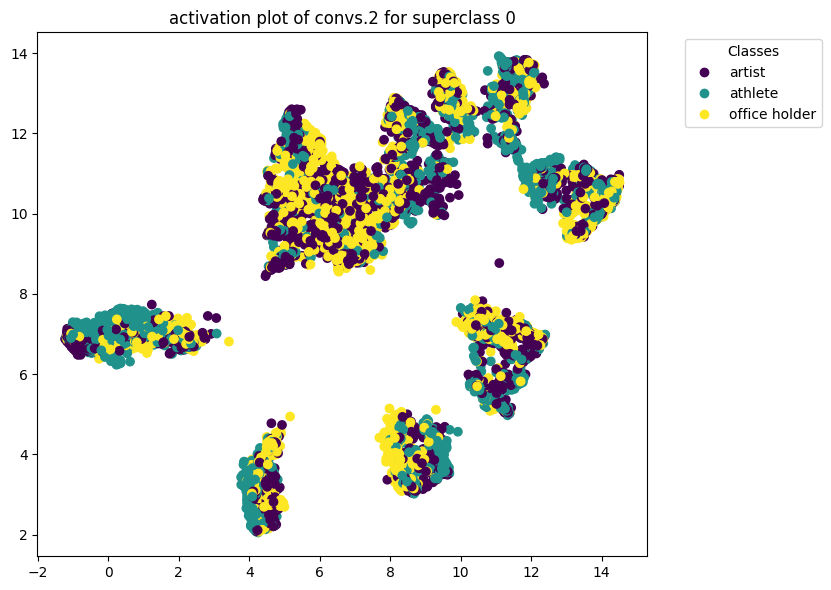

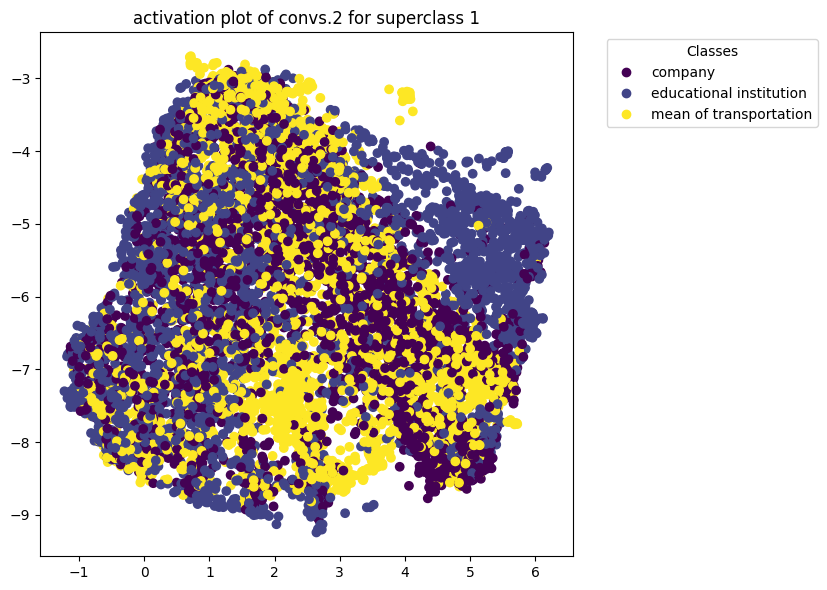

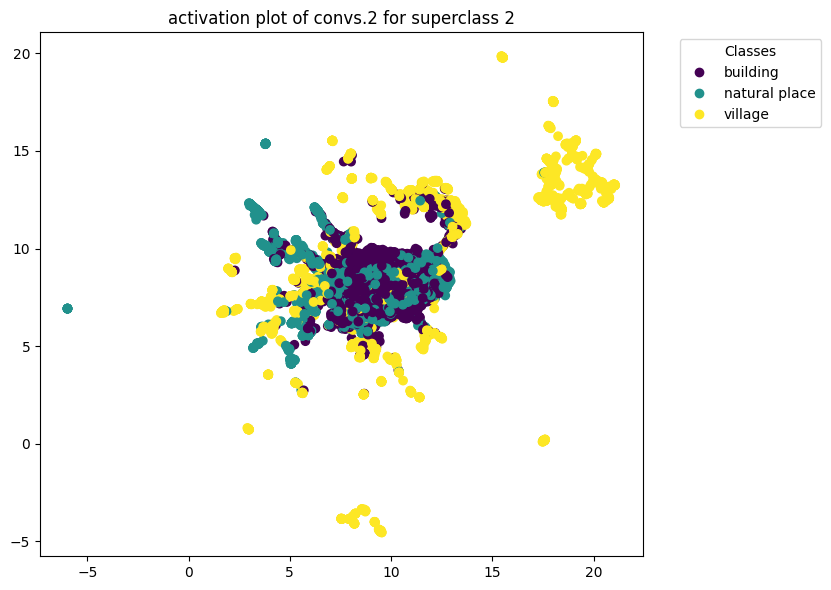

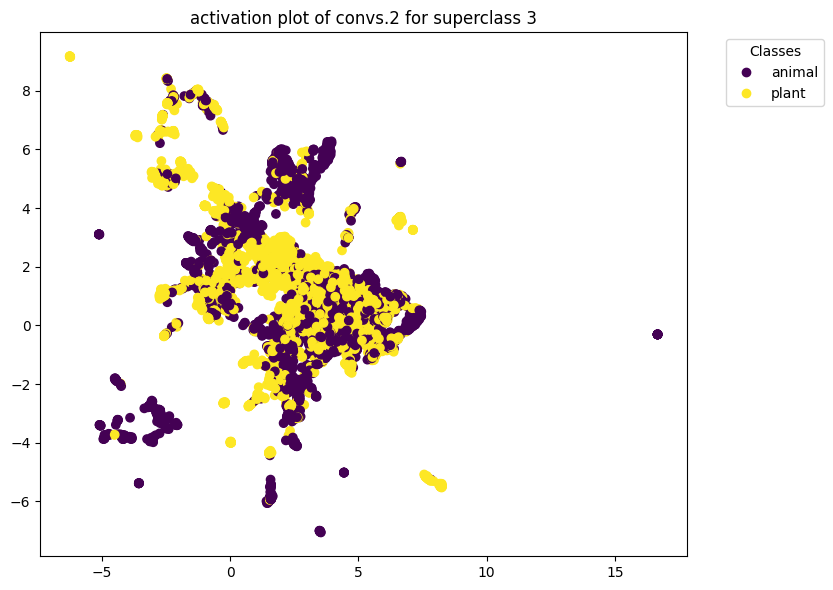

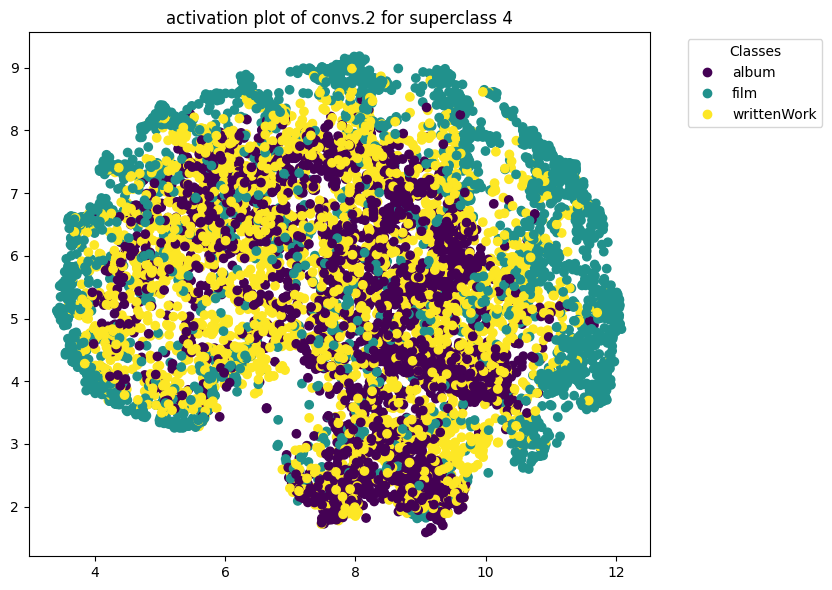

In [54]:
### complete.....
import matplotlib.pyplot as plt


for filtered_superclass in range(5):
 



    ## first  construc the binary mask

    superclasses_np = np.array(superclasses)

    mask = superclasses_np == filtered_superclass

    filtered_activations = selected_activations.numpy()[mask]

    filtered_subclass_lables = subclasses.numpy()[mask]


    unique_labels = np.unique(filtered_subclass_lables)

    print(unique_labels)

    filtered_subclass_names = [ name for i, name in enumerate(subclass_names) if i in unique_labels]

    print(filtered_subclass_names)




    reducer = umap.UMAP(random_state=seed)
    filted_embedding = reducer.fit_transform(filtered_activations)





    # Set the figure size to make the plot wider
    plt.figure(figsize=(10, 6))  # Adjust width (12) and height (6) as desired


    # Create scatter plot
    scatter = plt.scatter(filted_embedding[:, 0], filted_embedding[:, 1], c=filtered_subclass_lables, cmap="viridis")

    # Create legend and position it outside the plot to the right
    legend_elements, _ = scatter.legend_elements()
    plt.legend(legend_elements, filtered_subclass_names, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f"activation plot of {selected_conv} for superclass {filtered_superclass}")

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjusts the plot to leave room for the legend on the right



    plt.savefig(f"activation_plot_{selected_conv}_superclass_{filtered_superclass}.png")

## Transformer

In [ ]:
path = os.path.join("testRunArticles","collector.pt")
collector = torch.load(path)
epoch_1 = collector[0]
print(epoch_1.keys())

trainSplit = epoch_1["train_outputs"]
activations = trainSplit["activations"]
targets = trainSplit["targets"]
preds = trainSplit["preds"]
true_subclasses = trainSplit["true_subclass"]
print(targets.shape)
print(activations.shape)
print(preds.shape)
print(true_subclasses.shape)

In [ ]:
print(trainSplit.keys())

In [ ]:
print(trainSplit["true_subclass"].shape)
print(trainSplit["targets"].shape)

In [ ]:
print(targets.unique())
print(trainSplit["true_subclass"].unique())

In [ ]:
print(activations.shape)
print(targets.shape)
print(preds.shape)
print(true_subclasses.shape)

In [ ]:
selcted_superclass = 3

In [ ]:
selected_activations = activations[targets == selcted_superclass]
selected_subclasses = true_subclasses[targets == selcted_superclass]

In [ ]:
import umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(selected_activations)


In [ ]:
print(embedding.shape)
print(selected_subclasses.shape)


print(selected_subclasses.unique())

In [ ]:
true_subclass_names = [
        " 0 - Company",
        " 1 - Educational Institution",
        " 2 - Artist",
        " 3 - Athlete",
        " 4 - Office Holder",
        " 5 - Mean of Transportation",
        " 6 - Building",
        " 7 - Natural Place",
        " 8 - Village",
        " 9 - Animal",
        "10 - Plant",
        "11 - Album",
        "12 - Film",
        "13 - Written Work",
    
    ]

In [ ]:
used_subclass_names = [true_subclass_names[i] for i in selected_subclasses.unique()]
print(used_subclass_names)

In [ ]:
import matplotlib.pyplot as plt
scatter = plt.scatter(embedding[:,0], embedding[:,1])
plt.legend()

In [ ]:
### plot the embedding
import matplotlib.pyplot as plt
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],s =1,c = selected_subclasses, cmap='tab20')
legend = plt.legend(handles=scatter.legend_elements()[0], labels=used_subclass_names, title="Classes", loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()